In [1]:
import json, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_sample(index):
    dt = pd.read_csv(f'../../data/GIAB/_las_noappr/HG00{index}_p14.lasbed', sep=' ')
    dt = dt[dt['covered_bases'] > 0].copy()
    dt['SN'] = index
    return dt

LB = pd.concat([load_sample(i) for i in range(1,7)])

---

## Схема построения обобщённой метрики:

1. Из первых 4 образцов GIAB выбираются реальные регионы, с однозначно хорошим сигналом покрытия: полностью покрытые, пересечение с `all_diff` < 5%. Для них строится распределение метрики `FFT_dF`. Для этих регионов извлекаются константы нормировки метрик для сведения итогового распределения к Std == 1 и 99% квантилю к 10.

In [15]:
real_good = LB.loc[(LB['SN'] <= 2) & (LB['all_diff'] < 0.05) & (LB['covered_bases'] == 1)]
fs = np.std(real_good['FFT_dF'])
Q95 = np.quantile(LB['FFT_dF'].loc[(LB['SN'] > 2) & (LB['SN'] <= 3)], 0.95) # Порог перехода от FFT к DTCWT
print("FFT Std: ", fs)
print("FFT Q95: ", Q95)

FFT Std:  289.49012689247957
FFT Q95:  3510.6100249999977


2. Метрика делится на "грубую" `FFT_dF`, чувствительную к большим возмущениям, и "тонкую" `DTCWT_Entropy`, которая может заметить аберрации даже в одну базу. Первой применяется грубая метрика `FFT_dF`. Если её значения для анализируемого региона лежат за пределами 99% квантиля распределения образцовых очень хороших данных, то мы считаем, что регион содержит достаточное аберраций, чтобы они были замечены `FFT_dF`. В этом случае возвращаем значение `FFT_dF` отнормированное таким образом, чтобы 99% приходился на 10. Следовательно, все значения `FFT_dF` не меньше 10.

3. В противном же случае, если значения для метрики `FFT_dF` принадлежат 99% квантилю распределения образцовых очень хороших регионов, мы считаем, что аберрации в этих регионах настолько малы, что не могут быть сдетектированы метрикой `FFT_dF`. На таких образцах считается метрика `DTCWT_Entropy`. Чем больше значения этой метрики, тем более спокойный регион в рассмотрении. По этому значения `DTCWT_Entropy` инвертируются и приводятся к интервалу от 0 до 10 таким образом, чтобы распределение для всех хороших (в смысле `FFT_dF`) регионов было равномерным.

### Примеры

In [16]:
q_fft = np.quantile(LB['FFT_dF'], (0.05, 0.95))
q_dtt = np.quantile(LB['DTCWT_Entropy'], (0.05, 0.95))

def plts(tmp):
    alpha = max(5/len(tmp), 5/20)
    for row in tmp.filter(items=['#chr', 'start', 'end', 'SN']).values.tolist()[0:20]:
        sig = requests.post(f'http://127.0.0.1:9950/depth/HG00{row[3]}', json=[row]).json()
        plt.plot(sig[0], color="#000", alpha=alpha)
    plt.show()

In [17]:
# Регионы, сильно хороших по мнению FFT_dF и содержащих аберрацию, по мнению DTCWT_Entropy
_GB = LB.loc[(LB['FFT_dF'] < q_fft[0]) & (LB['DTCWT_Entropy'] < q_dtt[0])]
_GB

,#chr,start,end,FFT_dF,DWT_Energy_Entropy,DTCWT_Entropy,Std,covered_bases,mean,variance,skewness,hc_vcf,lc_vcf,all_diff,acent,SN
740,chr1,12124161,12140544,1435.2397,2.2281,8.8678,0.1207,1.0000,260.5753,1078.3059,-0.1664,0.2265,0.0,0.1023,0.0,1
777,chr1,12730369,12746752,1354.4709,2.2611,8.8207,0.1320,1.0000,301.9561,1288.6423,-0.2615,0.0000,0.0,0.1099,0.0,1
1062,chr1,17399809,17416192,1268.2316,2.1976,8.8382,0.1038,1.0000,253.5134,797.3365,-1.0682,0.1179,0.0,0.2314,0.0,1
1096,chr1,17956865,17973248,1469.5347,2.2261,8.9071,0.1187,0.9999,250.2601,1043.2054,-0.3131,0.3360,0.0,0.0493,0.0,1
2024,chr1,33161217,33177600,1368.7388,2.2261,8.8837,0.1104,1.0000,249.9000,902.0476,-0.3641,0.1767,0.0,0.0990,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130695,chr13,64143361,64159744,1407.8794,2.1602,8.8987,0.1310,0.9999,55.6550,47.3956,-0.4637,0.3596,0.0,0.2663,0.0,4
133349,chr13,107626497,107642880,1461.6420,2.1674,8.7577,0.1352,0.9997,55.1490,50.4896,-0.3375,0.3603,0.0,0.1629,0.0,4
144466,chr15,68337665,68354048,1423.8657,2.1518,8.9173,0.1296,0.9999,54.4588,46.3855,0.0476,0.3359,0.0,0.0319,0.0,4
170130,chr21,9748481,9764864,1413.9111,1.9795,8.9029,0.3693,1.0000,156.6273,376.5190,-0.6583,0.0000,0.0,1.0000,1.0,4


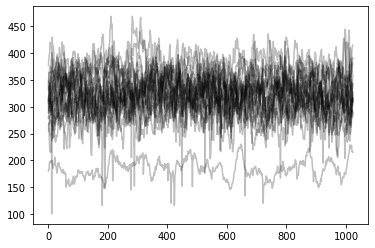

In [19]:
plts(_GB.sort_values(by=['FFT_dF'], ascending=True)[0:20])

In [6]:
# Противоречивые регионы: очень спокойные, по мнению DTCWT_Entropy и шумные по FFT_dF
_BG = LB.loc[(LB['FFT_dF'] > q_fft[1]) & (LB['DTCWT_Entropy'] > q_dtt[1])]
_BG

,#chr,start,end,FFT_dF,DWT_Energy_Entropy,DTCWT_Entropy,Std,covered_bases,mean,variance,skewness,hc_vcf,lc_vcf,all_diff,acent,SN
7358,chr1,120553473,120569856,4692.5464,2.0117,9.2117,0.3338,1.0000,193.3405,8246.3706,0.2601,0.0000,0.0000,1.0000,0.0,1
8941,chr1,146489345,146505728,4376.6977,2.0082,9.2170,0.2129,1.0000,135.1533,3353.8809,1.0229,0.0000,0.0000,1.0000,0.0,1
9065,chr1,148520961,148537344,4340.8492,2.0313,9.2125,0.3870,1.0000,248.2728,11084.6088,2.2932,0.0000,0.0000,1.0000,0.0,1
11976,chr1,196214785,196231168,4307.8782,1.6438,9.2151,0.3896,1.0000,252.6630,11229.5265,-0.5944,0.0640,0.0245,0.5822,0.0,1
23099,chr2,129482753,129499136,4460.0462,1.5661,9.2251,0.3368,1.0000,208.9190,8395.6223,0.5531,0.0491,0.0000,0.0783,0.0,1
23170,chr2,130646017,130662400,4612.4573,1.9669,9.2168,0.4665,1.0000,276.5233,16104.1881,0.9140,0.0000,0.0000,1.0000,0.0,1
105147,chr10,47759361,47775744,4955.7417,1.9421,9.2203,0.2726,0.9998,146.2884,5498.7644,0.5094,0.0000,0.0123,1.0000,0.0,1
135224,chr14,23969793,23986176,4392.2201,1.5119,9.2332,0.2987,1.0000,188.9940,6603.3459,0.5891,0.0000,0.0804,1.0000,0.0,1
148595,chr16,33980417,33996800,4387.3391,2.1381,9.2277,0.2422,1.0000,153.3129,4342.0747,0.2911,0.0000,0.0000,1.0000,0.0,1
173326,chr22,15400961,15417344,4394.3495,2.0072,9.2165,0.3325,1.0000,209.9332,8179.7882,0.2885,0.0000,0.0000,1.0000,1.0,1


Total: 10


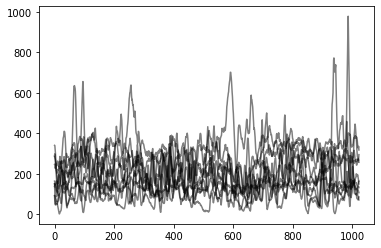

In [7]:
print("Total:", len(_BG))
plts(_BG)

In [8]:
# Спокойные по всем метрикам
_GG = LB.loc[(LB['FFT_dF'] < q_fft[0]) & (LB['DTCWT_Entropy'] > q_dtt[1])]
_GG

,#chr,start,end,FFT_dF,DWT_Energy_Entropy,DTCWT_Entropy,Std,covered_bases,mean,variance,skewness,hc_vcf,lc_vcf,all_diff,acent,SN
85,chr1,1392641,1409024,1394.6568,2.1143,9.2481,0.1180,1.0,262.9964,1029.5647,-0.2248,0.0123,0.0,0.2010,0.0,1
109,chr1,1785857,1802240,1429.7593,2.1214,9.2380,0.1229,1.0,267.2607,1118.2507,0.2275,0.0491,0.0,0.0569,0.0,1
131,chr1,2146305,2162688,1335.5402,2.0594,9.2535,0.1085,1.0,252.9867,871.7205,0.1856,0.0000,0.0,0.3032,0.0,1
145,chr1,2375681,2392064,1126.4075,2.1199,9.2373,0.0912,1.0,252.4943,614.8360,-0.7381,0.0821,0.0,0.3874,0.0,1
151,chr1,2473985,2490368,1471.0542,2.1664,9.2163,0.1173,1.0,247.7957,1018.9808,-0.7780,0.0491,0.0,0.6015,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175326,chr22,48168961,48185344,1263.9711,2.0681,9.2426,0.0995,1.0,245.3500,733.0885,-0.0151,0.0123,0.0,0.0573,0.0,1
175349,chr22,48545793,48562176,1456.5244,1.9675,9.2482,0.1107,1.0,236.2339,906.9521,0.9050,0.0368,0.0,0.2674,0.0,1
175442,chr22,50069505,50085888,1313.1638,2.0575,9.2409,0.1074,1.0,254.5657,853.3954,-0.2050,0.1284,0.0,0.3860,0.0,1
175482,chr22,50724865,50741248,1479.6181,1.9288,9.2132,0.1155,1.0,242.4562,987.2338,-0.2246,0.0613,0.0,0.2714,0.0,1


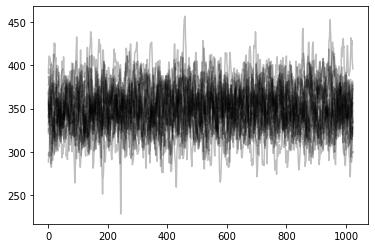

In [9]:
plts(_GG.sort_values(by=['FFT_dF'], ascending=True)[0:20])

---

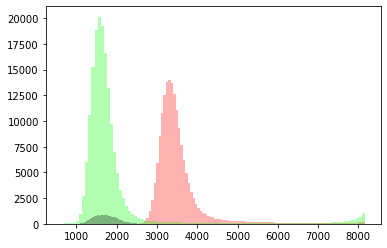

In [10]:
# real_good = LB.loc[(LB['SN'] <= 4) & (LB['all_diff'] < 0.05) & (LB['covered_bases'] == 1)]
plt.hist(LB[LB['SN'] == 6]['FFT_dF'], bins=100, color="#f00", alpha=0.3)
plt.hist(LB[LB['SN'] == 1]['FFT_dF'], bins=100, color="#0f0", alpha=0.3)
plt.hist(real_good['FFT_dF'], bins=100, color="#000", alpha=0.3)
plt.show()

In [20]:
# Регионы, переходящие в DTCWT
fft_good = LB.loc[(LB['FFT_dF'] < Q95) & (LB['SN'] <= 4)]

# Построение функции преобразования значений DTCWT_Entropy в интервал [0,1]
sv = sorted(fft_good['DTCWT_Entropy'].values)
grid = [sv[0]]
for k, cs in enumerate(np.cumsum(sv)/sum(sv)):
    if cs > len(grid) / 100: grid.append(sv[k])

def normal(v):
    if v < grid[0]: return 1
    if v > grid[-1]: return 0
    for i in range(len(grid) - 1):
        if grid[i] > v or v > grid[i+1]: continue
        return (1 - (i + (v - grid[i])/(grid[i+1] - grid[i]))/(len(grid) - 1)) * 10

In [21]:
def join(row):
    if row['FFT_dF'] < Q95: return normal(row['DTCWT_Entropy'])
    return (row['FFT_dF'] - Q95)/fs + 10

LB['tree'] = LB.apply(lambda row: join(row), axis = 1)

В процентах указано число регионов, попавших в метрику DTCWT_Entropy, т.е. хороших с т.з. FFT_dF

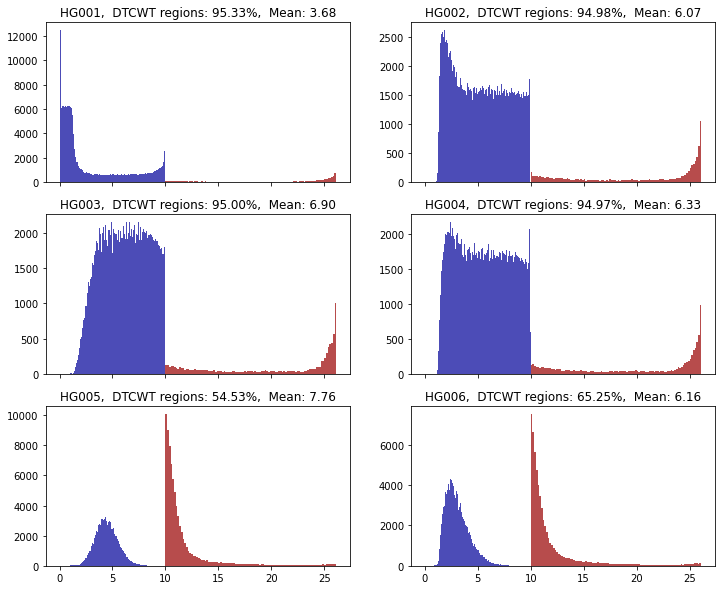

In [30]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(12, 10))
for i in range(1, 7):
    T, ax = (LB[LB['SN'] == i], axs.flat[i-1])
    ax.hist(T[T['tree'] <= 10]['tree'], bins=100, color='#009', alpha=0.7)
    ax.hist(T[T['tree'] >= 10]['tree'], bins=100, color='#900', alpha=0.7)
    pr = len(T[T['tree'] <= 10])/len(T) * 100
    nm = T['tree'].mean()
    ax.set_title(f"HG00{i},  DTCWT regions: {pr:.2f}%,  Mean: {nm:.2f}")

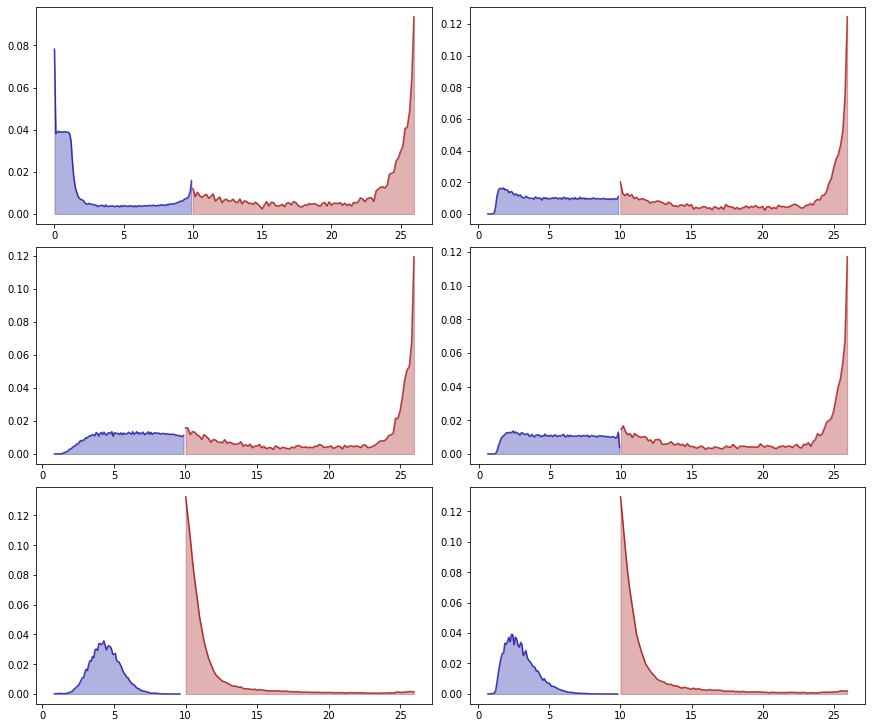

In [26]:
def hst(ax, data, color):
    y, x = np.histogram(data, bins=100)
    # y, x = (x[0:-1], y)
    y, x = (x[0:-1], y/sum(y))
    ax.plot(y, x, alpha=0.7, color=color)
    ax.fill_between(y, x, alpha=0.3, color=color)    

fig, axs = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True)
for i in range(1, 7):
    T, ax = (LB[LB['SN'] == i], axs.flat[i-1])
    ddt = [normal(v) for v in T[T['FFT_dF'] <= Q95]['DTCWT_Entropy'].values]
    hst(ax, ddt, '#009')
    fft = (T[T['FFT_dF'] >= Q95]['FFT_dF'] - Q95)/fs + 10
    hst(ax, fft, '#900')

In [29]:
"grid = [" + ",".join([str(s) for s in grid]) + "]"

'grid = [8.1858,8.8536,8.8958,8.9203,8.938,8.9518,8.9629,8.972,8.98,8.9872,8.9935,8.9991,9.0044,9.0092,9.0137,9.018,9.0219,9.0257,9.0293,9.0327,9.0359,9.039,9.0419,9.0447,9.0474,9.05,9.0526,9.055,9.0573,9.0595,9.0618,9.0639,9.066,9.068,9.0701,9.072,9.0739,9.0758,9.0776,9.0794,9.0812,9.0829,9.0846,9.0862,9.0878,9.0894,9.091,9.0925,9.094,9.0956,9.097,9.0985,9.0999,9.1014,9.1028,9.1041,9.1055,9.1069,9.1083,9.1097,9.111,9.1123,9.1137,9.115,9.1163,9.1176,9.119,9.1203,9.1216,9.123,9.1244,9.1257,9.1271,9.1286,9.13,9.1316,9.1332,9.1348,9.1365,9.1383,9.1403,9.1424,9.1447,9.1474,9.1507,9.1549,9.1608,9.1688,9.1775,9.1859,9.1943,9.2024,9.2103,9.2183,9.2261,9.2334,9.2403,9.2468,9.2529,9.2595]'